In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
read_file = pd.read_csv('train.csv')
poverty_df = pd.DataFrame(read_file)

#Part 1: Prepare household level data
household_level = ['Id', 'idhogar', 'rooms', 'refrig', 'bedrooms', 'television', 'qmobilephone', 
                   'v18q1', 'v2a1', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1', 
                   'r4t2', 'r4t3', 'tamhog', 'tamviv', 'hhsize']
household_level_df = poverty_df[household_level].sort_values('idhogar').fillna('0')

#Part 2: Prepare housing data
wall_material = ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']
floor_material = ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']
roof_material = ['techozinc', 'techoentrepiso', 'techocane', 'techootro']
water_provision = ['abastaguadentro', 'abastaguafuera', 'abastaguano']
electricity = ['public', 'planpri', 'noelec', 'coopele']
toilet = ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']
cooking_energy = ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4']
rubbish_disposal = ['elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 'elimbasu5', 'elimbasu6']
wall_condition = ['epared1', 'epared2', 'epared3']
roof_condition = ['etecho1', 'etecho2', 'etecho3']
floor_condition = ['eviv1', 'eviv2', 'eviv3']
house_financing = ['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']
house_location = ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6']
house_area = ['area1', 'area2']

##create list of lists to iterate through with function
house_information = [wall_material, floor_material, roof_material, water_provision, electricity, toilet, 
                    cooking_energy, rubbish_disposal, wall_condition, roof_condition, floor_condition, 
                    house_financing, house_location, house_area]

##create list of strings for new column names
house_information_str = ['wall_material', 'floor_material', 'roof_material', 'water_provision', 'electricity', 'toilet', 
                    'cooking_energy', 'rubbish_disposal', 'wall_condition', 'roof_condition', 'floor_condition', 
                    'house_financing', 'house_location', 'house_area']

##loop through each row of each item in each list in house_information list to collapse columns
def collapse_columns(housing_data_list):
    new_df = []
    for item in housing_data_list:
        for i in range(len(poverty_df)):
            if poverty_df[item][i] == 1:
                new_df.append(item)
            else:
                pass
    return pd.DataFrame(new_df)

##rename columns with the list of strings for new column names
cols = list(household_level_df.columns.values) + house_information_str


##fill in house_hold_level_df with collapsed columns
for i in range(len(house_information)):
    household_level_df = pd.concat([household_level_df, collapse_columns(house_information[i])], axis=1)

household_level_df.columns = cols
display(household_level_df.sort_values('idhogar').head())


,Id,idhogar,rooms,refrig,bedrooms,television,qmobilephone,v18q1,v2a1,r4h1,...,electricity,toilet,cooking_energy,rubbish_disposal,wall_condition,roof_condition,floor_condition,house_financing,house_location,house_area
7472,ID_654683e33,001ff74ca,6,1,4,0,1,1,0,0,...,public,sanitario3,energcocinar3,elimbasu1,epared3,etecho3,eviv3,tipovivi3,lugar4,area2
7471,ID_389eb5f20,001ff74ca,6,1,4,0,1,1,0,0,...,public,sanitario3,energcocinar3,elimbasu1,epared3,etecho3,eviv3,tipovivi3,lugar4,area2
8159,ID_55199c2f3,003123ec2,3,1,2,0,2,0,0,2,...,public,sanitario3,energcocinar3,elimbasu1,epared3,etecho3,eviv3,tipovivi3,lugar5,area2
8160,ID_5bef9b553,003123ec2,3,1,2,0,2,0,0,2,...,public,sanitario3,energcocinar3,elimbasu1,epared3,etecho3,eviv3,tipovivi3,lugar5,area2
8161,ID_079963679,003123ec2,3,1,2,0,2,0,0,2,...,public,sanitario3,energcocinar3,elimbasu1,epared3,etecho3,eviv3,tipovivi3,lugar5,area2


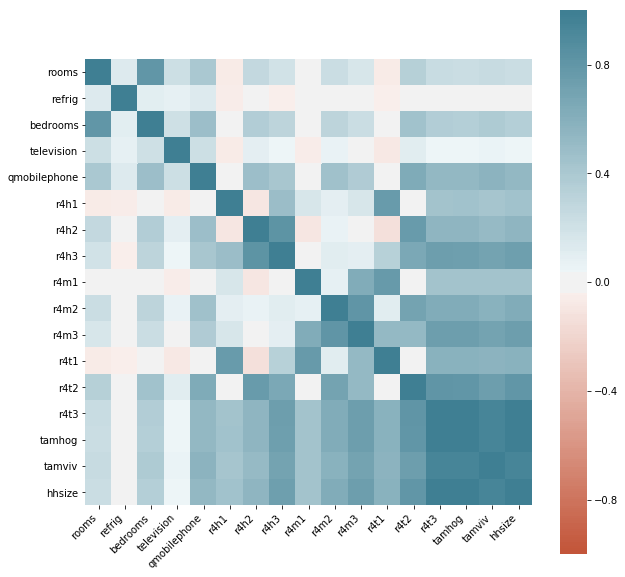

In [12]:
#Part 3: Feature reduction using heatmap
corr = household_level_df.corr()

plt.figure(figsize = (10,10))

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Text(0.5,0,'Name')

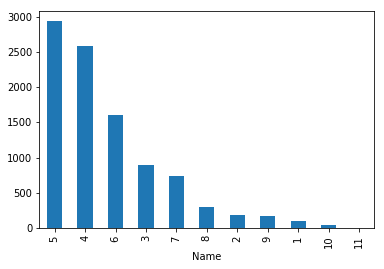

In [7]:
ax = household_level_df['rooms'].value_counts().sort_values(ascending=False).plot(kind='bar')
ax.set_xlabel("Name")

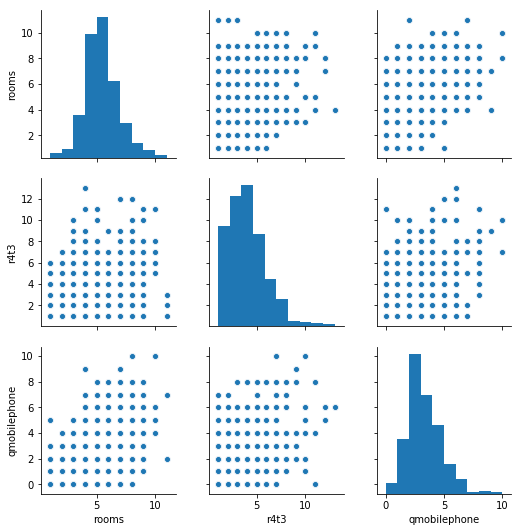

In [25]:
abc = household_level_df[['rooms', 'r4t3', 'qmobilephone']]

sns.pairplot(abc)

In [ ]:
plt.figure(figsize = (10,10))
sns.countplot(household_level_df['v18q1'])

In [19]:
household_level_df['v2a1'].value_counts().sort_values(ascending=False)[:5]

0           6860
150000.0     233
100000.0     181
200000.0     159
120000.0     149
Name: v2a1, dtype: int64